# Discriminative vs. Generative Modeling for Cardiovascular Risk Prediction 


### adding libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading dataset


In [4]:
# Step 1: Load the dataset
df = pd.read_csv("data/heart_disease_uci.csv")  # replace with your actual file path if needed

In [5]:
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


# Task 1: Data Exploration & Gaussian Fitting

### • Handle missing or invalid values via deletion or imputation. 


In [6]:
# Step 2: Drop irrelevant columns
# df.drop(columns=["id", "dataset"], inplace=True)

# Step 3: Binarize target column
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
# df.drop(columns=["num"], inplace=True)

# Step 4: Drop rows with any missing values
df.dropna(inplace=True)

# Step 5: Check remaining shape and confirm no missing values
print("Data shape after dropping missing values:", df.shape)
print("Remaining missing values:\n", df.isnull().sum())

Data shape after dropping missing values: (299, 17)
Remaining missing values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
target      0
dtype: int64


### • Plot distributions (histogram or KDE) of all features per class. 


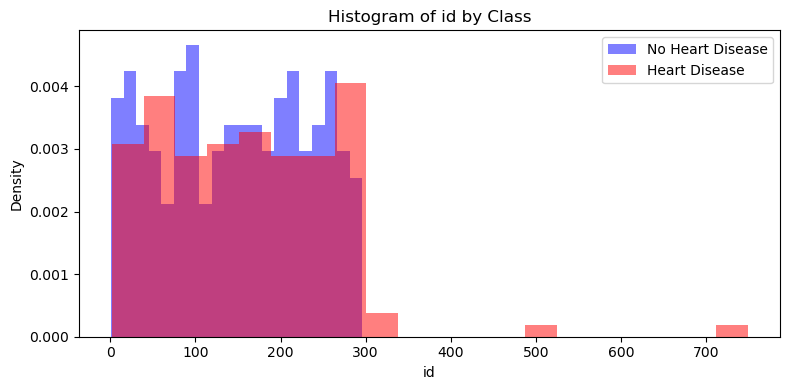

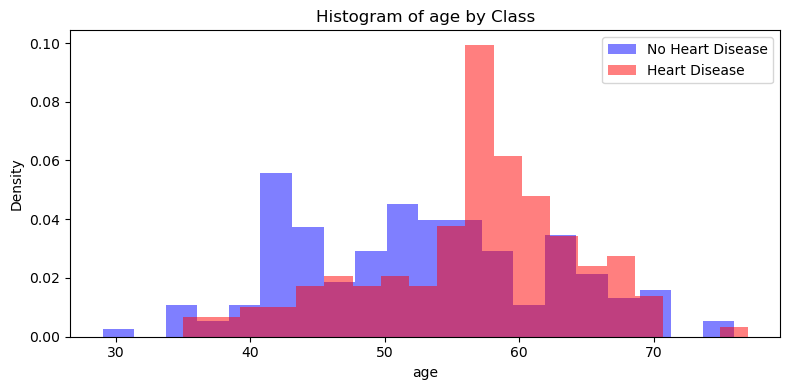

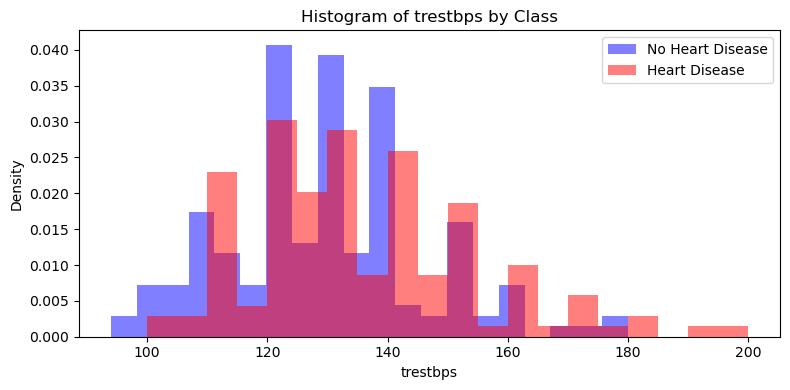

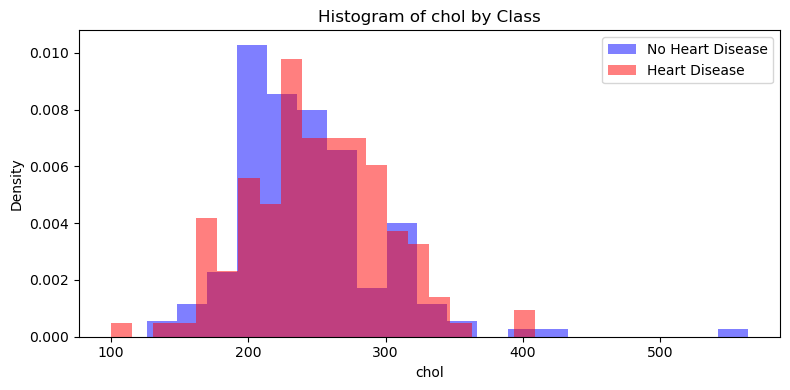

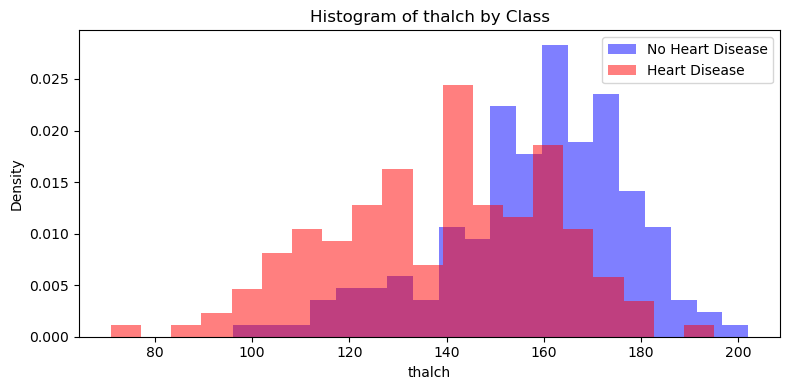

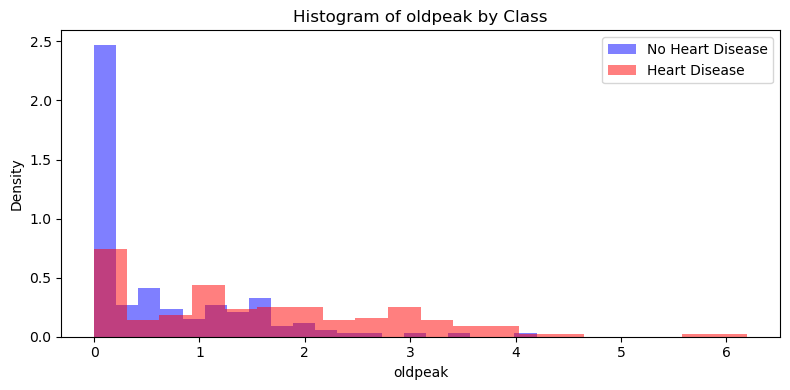

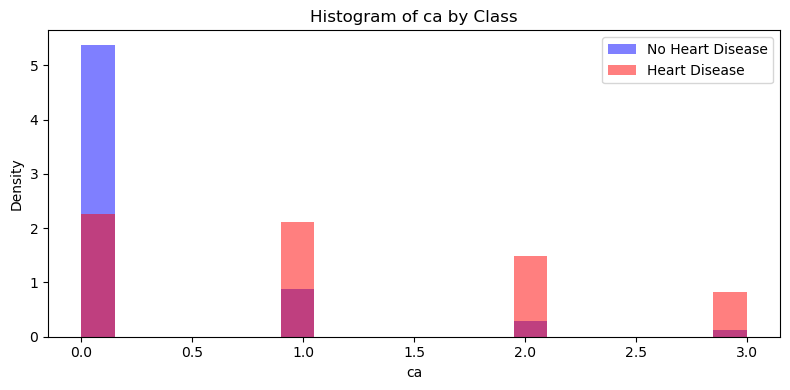

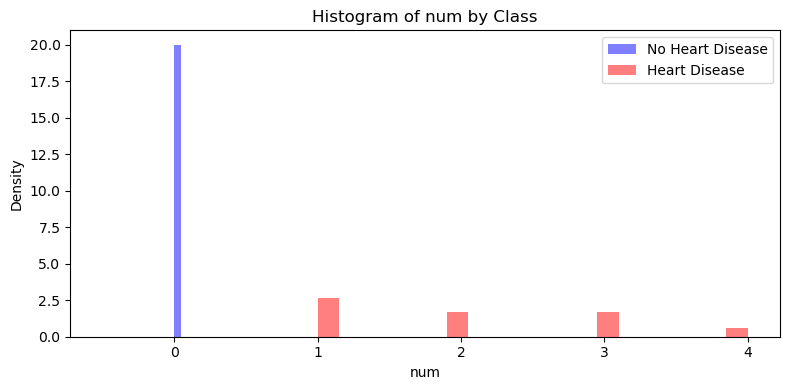

In [7]:
# Get list of numeric columns (excluding target)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop("target")

# Plot histogram for each numeric column, separated by class
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(df[df["target"] == 0][col], bins=20, alpha=0.5, label="No Heart Disease", color="blue", density=True)
    plt.hist(df[df["target"] == 1][col], bins=20, alpha=0.5, label="Heart Disease", color="red", density=True)
    plt.title(f"Histogram of {col} by Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


### • Select two informative features (e.g., chol and thalach). 


In [8]:
# Select the two features: 'chol' and 'thalch'
selected_features = ["chol", "thalch", "target"]

# Extract subset
df_selected = df[selected_features]

# Display first few rows
print(df_selected.head())

    chol  thalch  target
0  233.0   150.0       0
1  286.0   108.0       1
2  229.0   129.0       1
3  250.0   187.0       0
4  204.0   172.0       0


### Fit 2D Gaussian distributions (one per class) and plot contour maps.

C:\Users\prca\AppData\Local\Temp\ipykernel_14892\802404007.py:33: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z0, levels=5, colors='blue', linestyles='dashed', label="No Heart Disease")
C:\Users\prca\AppData\Local\Temp\ipykernel_14892\802404007.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z1, levels=5, colors='red', linestyles='solid', label="Heart Disease")


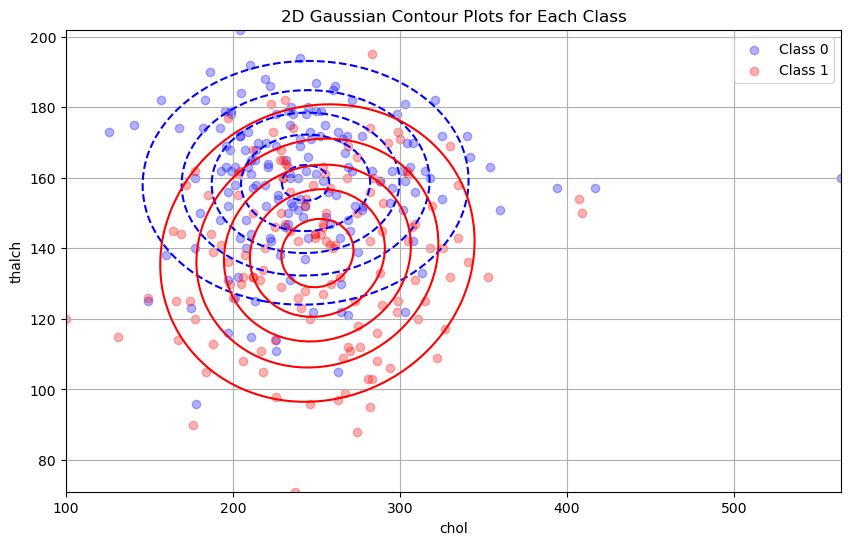

In [9]:
# Step 1: Extract data by class
X0 = df_selected[df_selected["target"] == 0][["chol", "thalch"]].values
X1 = df_selected[df_selected["target"] == 1][["chol", "thalch"]].values

# Step 2: Compute means and covariances
mu0 = np.mean(X0, axis=0)
mu1 = np.mean(X1, axis=0)
cov0 = np.cov(X0, rowvar=False)
cov1 = np.cov(X1, rowvar=False)

# Step 3: Create a mesh grid
x = np.linspace(df_selected["chol"].min(), df_selected["chol"].max(), 100)
y = np.linspace(df_selected["thalch"].min(), df_selected["thalch"].max(), 100)
X, Y = np.meshgrid(x, y)
grid = np.stack([X.ravel(), Y.ravel()], axis=1)

# Step 4: Multivariate Gaussian PDF function
def gaussian_pdf(x, mean, cov):
    d = mean.shape[0]
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2*np.pi), d/2) * np.sqrt(det))
    diff = x - mean
    result = norm_const * np.exp(-0.5 * np.sum(diff @ inv * diff, axis=1))
    return result

# Step 5: Evaluate PDF on grid
Z0 = gaussian_pdf(grid, mu0, cov0).reshape(X.shape)
Z1 = gaussian_pdf(grid, mu1, cov1).reshape(X.shape)

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z0, levels=5, colors='blue', linestyles='dashed', label="No Heart Disease")
plt.contour(X, Y, Z1, levels=5, colors='red', linestyles='solid', label="Heart Disease")
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.3, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.3, label="Class 1")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.title("2D Gaussian Contour Plots for Each Class")
plt.legend()
plt.grid(True)
plt.show()


### • Evaluate Gaussian assumption via plots and normality tests. 



📊 Evaluating Normality for: chol | Class 0


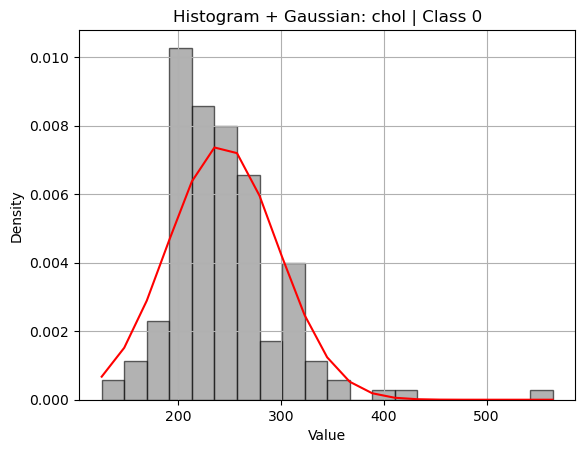

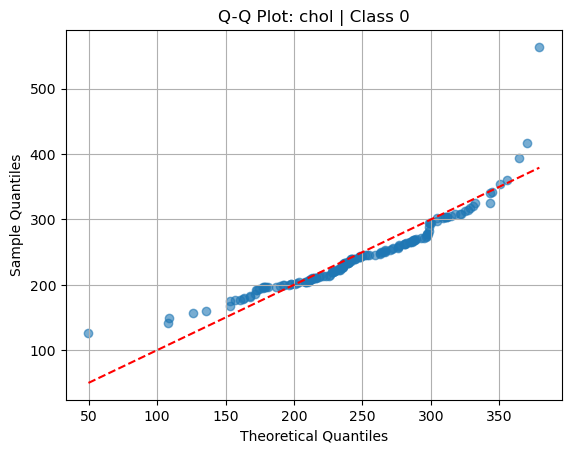


📊 Evaluating Normality for: chol | Class 1


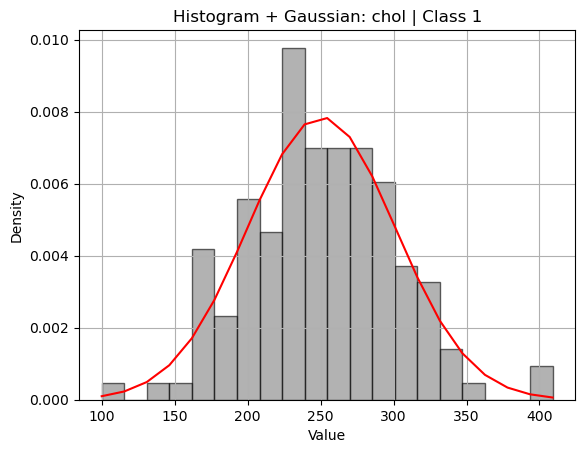

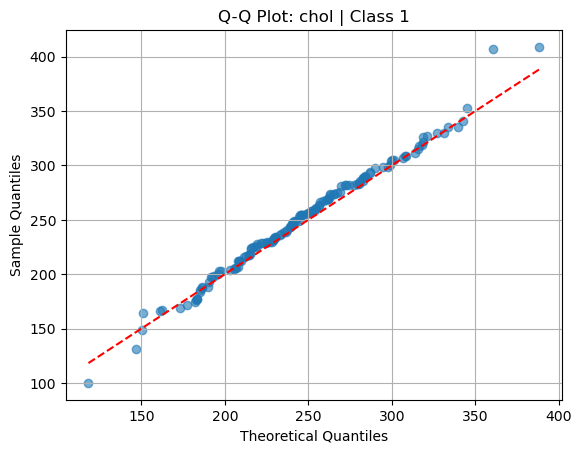


📊 Evaluating Normality for: thalch | Class 0


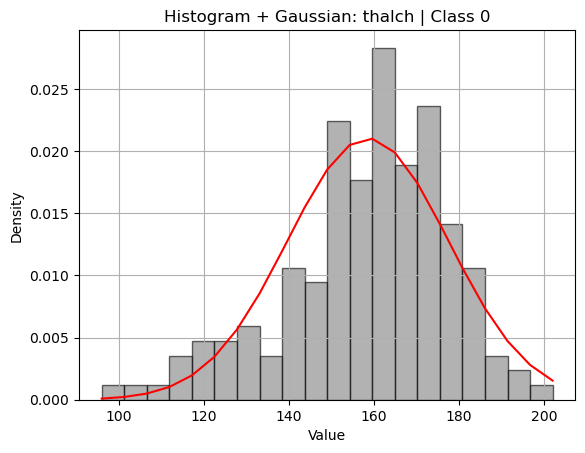

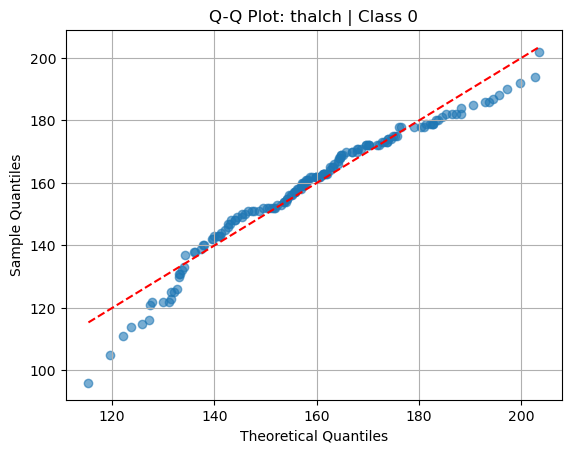


📊 Evaluating Normality for: thalch | Class 1


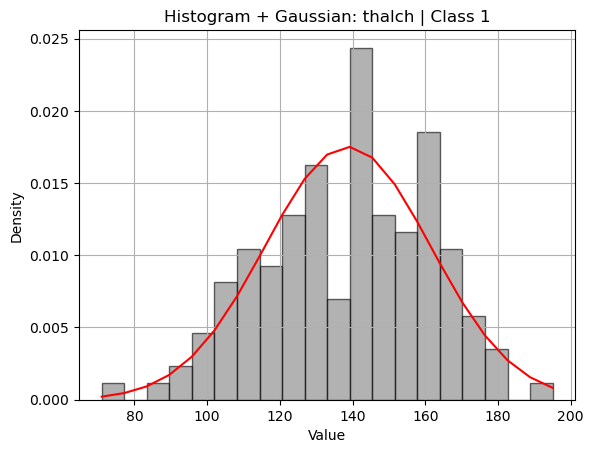

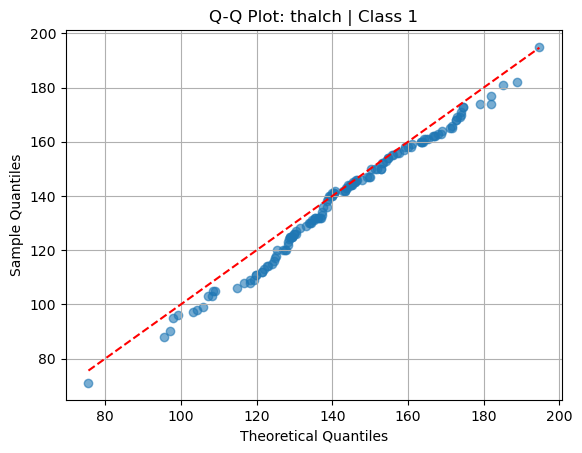

In [10]:

# Helper: Plot histograms with normal curve
def plot_hist_with_gaussian(data, title):
    mu = np.mean(data)
    sigma = np.std(data)

    count, bins, _ = plt.hist(data, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black')
    gauss_curve = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(bins - mu)**2 / (2*sigma**2))
    plt.plot(bins, gauss_curve, color='red')
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

# Helper: Manual Q-Q plot
def qq_plot(data, title):
    sorted_data = np.sort(data)
    n = len(data)
    theoretical_q = np.sort(np.random.normal(np.mean(data), np.std(data), n))
    
    plt.scatter(theoretical_q, sorted_data, alpha=0.6)
    plt.plot(theoretical_q, theoretical_q, color='red', linestyle='--')
    plt.title("Q-Q Plot: " + title)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

# Analyze for each feature per class
for col in ["chol", "thalch"]:
    for label in [0, 1]:
        data = df_selected[df_selected["target"] == label][col].values
        title = f"{col} | Class {label}"

        print(f"\n📊 Evaluating Normality for: {title}")
        plot_hist_with_gaussian(data, f"Histogram + Gaussian: {title}")
        qq_plot(data, title)


# Task 2: Generative Modeling (Gaussian Classifier)

### • Estimate mean and covariance matrix for each class. 

In [11]:
# Extract feature matrix and labels
X = df_selected[["chol", "thalch"]].values
y = df_selected["target"].values

# Split by class
X0 = X[y == 0]
X1 = X[y == 1]

# Mean vectors
mu0 = np.mean(X0, axis=0)
mu1 = np.mean(X1, axis=0)

# Covariance matrices
cov0 = np.cov(X0, rowvar=False)
cov1 = np.cov(X1, rowvar=False)

# Display results
print("Class 0 (No Heart Disease):")
print("Mean vector:\n", mu0)
print("Covariance matrix:\n", cov0)

print("\nClass 1 (Heart Disease):")
print("Mean vector:\n", mu1)
print("Covariance matrix:\n", cov1)


Class 0 (No Heart Disease):
Mean vector:
 [243.49375 158.58125]
Covariance matrix:
 [[2889.87417453   19.5351022 ]
 [  19.5351022   362.64744497]]

Class 1 (Heart Disease):
Mean vector:
 [250.57553957 138.67625899]
Covariance matrix:
 [[2602.62287561   92.53550203]
 [  92.53550203  523.00312793]]


### • Derive and plot decision boundary (log-likelihood ratio). 


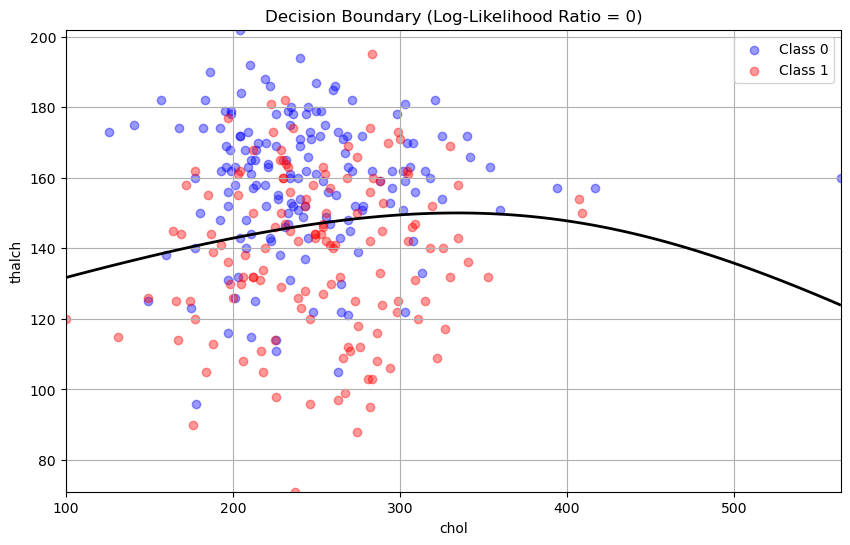

In [12]:
# Reuse mu0, mu1, cov0, cov1 from previous step
def multivariate_gaussian(x, mean, cov):
    size = mean.shape[0]
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2 * np.pi), size / 2) * np.sqrt(det))
    diff = x - mean
    exponent = -0.5 * np.sum(diff @ inv * diff, axis=1)
    return norm_const * np.exp(exponent)

# Mesh grid
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
y_vals = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]

# Evaluate densities
p0 = multivariate_gaussian(grid_points, mu0, cov0)
p1 = multivariate_gaussian(grid_points, mu1, cov1)

# Log-likelihood ratio
log_ratio = np.log(p1 + 1e-12) - np.log(p0 + 1e-12)  # add epsilon to avoid log(0)
log_ratio = log_ratio.reshape(X_grid.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='black', linewidths=2)
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.4, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.4, label="Class 1")
plt.title("Decision Boundary (Log-Likelihood Ratio = 0)")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


### Compare: 
o LDA (shared covariance) 

o QDA (distinct covariance) 

This plot will show:

Red dashed curve → QDA (curved boundary)

Blue solid line → LDA (linear boundary)

C:\Users\prca\AppData\Local\Temp\ipykernel_14892\2027179367.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, linestyles='--', label='QDA')
C:\Users\prca\AppData\Local\Temp\ipykernel_14892\2027179367.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio_lda, levels=[0], colors='blue', linewidths=2, linestyles='-', label='LDA')


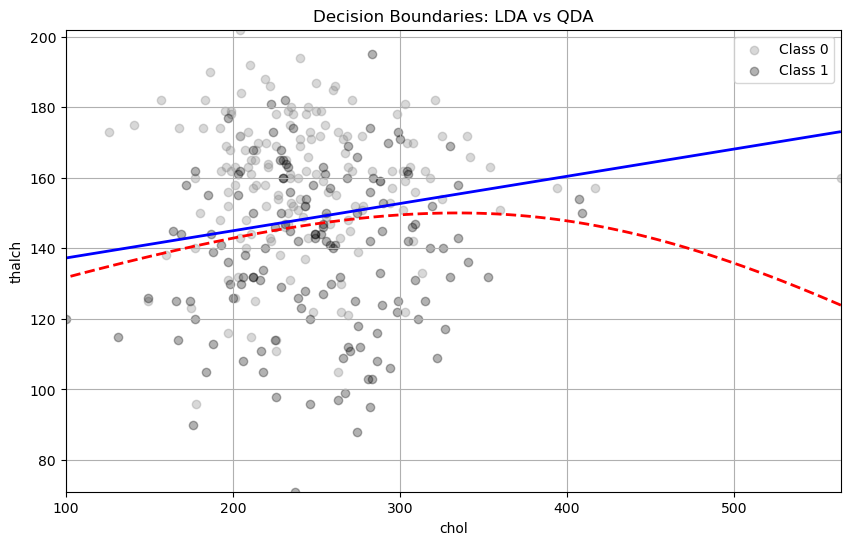

In [13]:
# Step 1: Shared covariance for LDA
shared_cov = (cov0 + cov1) / 2

# Step 2: Evaluate Gaussian with shared covariance for LDA
p0_lda = multivariate_gaussian(grid_points, mu0, shared_cov)
p1_lda = multivariate_gaussian(grid_points, mu1, shared_cov)
log_ratio_lda = np.log(p1_lda + 1e-12) - np.log(p0_lda + 1e-12)
log_ratio_lda = log_ratio_lda.reshape(X_grid.shape)

# Step 3: QDA was already done earlier (log_ratio)

# Step 4: Plot both boundaries
plt.figure(figsize=(10, 6))

# QDA
plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, linestyles='--', label='QDA')

# LDA
plt.contour(X_grid, Y_grid, log_ratio_lda, levels=[0], colors='blue', linewidths=2, linestyles='-', label='LDA')

# Data points
plt.scatter(X0[:, 0], X0[:, 1], color='gray', alpha=0.3, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='black', alpha=0.3, label="Class 1")

# Labels
plt.title("Decision Boundaries: LDA vs QDA")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


###  Discuss impact of covariance assumption.

Discussion: Impact of Covariance Assumption (LDA vs QDA)
What is the assumption?
LDA assumes all classes share the same covariance matrix.

QDA allows each class to have its own covariance matrix.

---

Impact on Modeling
| Aspect                | LDA (Shared Covariance)                  | QDA (Distinct Covariance)      |
| --------------------- | ---------------------------------------- | ------------------------------ |
| **Decision Boundary** | Linear (straight line)                   | Quadratic (curved)             |
| **Model Complexity**  | Lower                                    | Higher                         |
| **Overfitting Risk**  | Lower (good for small data)              | Higher (needs more data)       |
| **Speed**             | Faster (fewer parameters)                | Slower (more matrix inversion) |
| **Assumption**        | Features behave similarly across classes | Features can vary per class    |

---

When LDA Works Better

When class distributions are similar in shape/scale.

When you have limited data — more robust.

---

When QDA Works Better

When class distributions are clearly different (e.g., one class more spread out).

When you have enough data to reliably estimate covariance for each class.

---

In Your Plot:

If QDA's boundary curves and better separates classes, that suggests class-specific variability matters.

If both LDA and QDA give similar lines, then shared covariance (LDA) might be a safe and efficient choice.

### based on our plot
Analysis of Your Plot: LDA vs QDA

Blue Line = LDA (Linear Discriminant Analysis)

Red Dashed Curve = QDA (Quadratic Discriminant Analysis)

Gray Dots = Data points (Class 0 and 1)

---

Observations:

Shape of boundary:

LDA is a straight line (as expected).

QDA is curved and seems to adapt more flexibly to the data spread.

Data distribution:

The data isn’t perfectly separable with a straight line.

Class 1 (probably higher risk) is more spread out in thalch, and Class 0 is tighter.

Boundary alignment:

The QDA boundary curves away at high cholesterol values — suggesting the model is adapting to class-specific variance in that region.

LDA assumes uniform variance in all directions, which seems to oversimplify things here.

---

Which is better here?

QDA likely performs better in this case because:

The classes show different variances — QDA models that.

The decision boundary of QDA bends in areas where LDA can't adapt.

From the plot, QDA better separates the lower region (right side), where LDA crosses dense class 1 points.

---

Conclusion:

If you have enough data, QDA is preferred here.

If you're worried about overfitting or limited data, LDA is still safer.


### Task 3: Gaussian Naive Bayes 
• Implement from scratch assuming conditional independence.

In [14]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + 1e-6  # small value to avoid div-by-zero
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def _gaussian_logpdf(self, x, mean, var):
        return -0.5 * np.sum(np.log(2 * np.pi * var) + ((x - mean) ** 2) / var, axis=1)

    def predict(self, X):
        log_probs = []
        for c in self.classes:
            prior = np.log(self.priors[c])
            class_cond = self._gaussian_logpdf(X, self.mean[c], self.var[c])
            log_probs.append(prior + class_cond)
        return np.argmax(log_probs, axis=0)

In [15]:
# Prepare data
X_gnb = df_selected[["chol", "thalch"]].values
y_gnb = df_selected["target"].values

# Train model
gnb = GaussianNaiveBayes()
gnb.fit(X_gnb, y_gnb)

# Predict (on training data for now)
y_pred = gnb.predict(X_gnb)

# Accuracy
accuracy = np.mean(y_pred == y_gnb)
print(f"Training accuracy: {accuracy:.3f}")


Training accuracy: 0.709


### • Estimate per-feature mean/variance per class. 


In [16]:

# Get features and labels
X = df_selected[["chol", "thalch"]].values
y = df_selected["target"].values
classes = np.unique(y)

# Initialize containers
means = {}
variances = {}

# Loop over classes
for c in classes:
    X_c = X[y == c]
    means[c] = np.mean(X_c, axis=0)
    variances[c] = np.var(X_c, axis=0)

    print(f"\nClass {c}:")
    print("Mean:", means[c])
    print("Variance:", variances[c])



Class 0:
Mean: [243.49375 158.58125]
Variance: [2871.81246094  360.38089844]

Class 1:
Mean: [250.57553957 138.67625899]
Variance: [2583.89897003  519.2405155 ]


### • Compute posterior probabilities. 


In [17]:
# Log-Gaussian PDF
def log_gaussian_pdf(x, mean, var):
    return -0.5 * (np.log(2 * np.pi * var) + ((x - mean) ** 2) / var)

# Compute log-posteriors for all samples
log_posteriors = np.zeros((X.shape[0], len(classes)))

for idx, c in enumerate(classes):
    mean = means[c]
    var = variances[c]
    prior = np.log(np.sum(y == c) / len(y))  # log prior
    log_likelihood = log_gaussian_pdf(X, mean, var).sum(axis=1)  # sum over features
    log_posteriors[:, idx] = prior + log_likelihood

# Convert to probabilities (optional)
posteriors = np.exp(log_posteriors)
posteriors /= np.sum(posteriors, axis=1, keepdims=True)  # normalize

# Preview
print("Posterior probabilities for first 5 samples:")
print(posteriors[:5])


Posterior probabilities for first 5 samples:
[[0.58234111 0.41765889]
 [0.07982231 0.92017769]
 [0.31004299 0.68995701]
 [0.80080159 0.19919841]
 [0.77524823 0.22475177]]


### • Compare decision boundaries with Task 2. 


| Model                    | Covariance assumption              | Decision boundary shape                           |
| ------------------------ | ---------------------------------- | ------------------------------------------------- |
| **QDA (Task 2)**         | Full covariance matrix per class   | Curved / Flexible                                 |
| **Naive Bayes (Task 3)** | Diagonal covariance (independence) | Still curved but **axis-aligned** (less flexible) |


QDA -> red
Naive Bayes -> green

C:\Users\prca\AppData\Local\Temp\ipykernel_14892\1061839665.py:21: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, linestyles='--', label="QDA")
C:\Users\prca\AppData\Local\Temp\ipykernel_14892\1061839665.py:24: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio_gnb, levels=[0], colors='green', linewidths=2, linestyles='-', label="Naive Bayes")


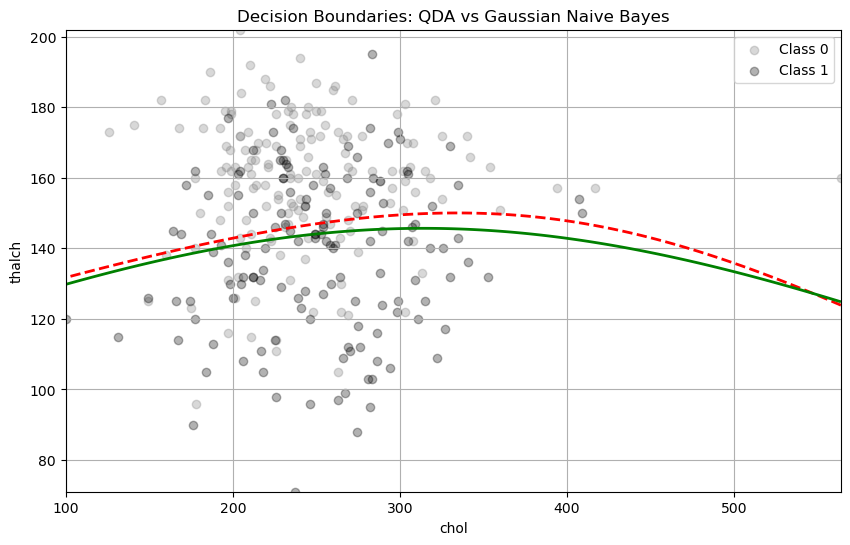

In [18]:
# Gaussian Naive Bayes log-posterior on the grid
def gnb_log_posteriors_grid(grid):
    log_post = np.zeros((grid.shape[0], len(classes)))
    for idx, c in enumerate(classes):
        mean = means[c]
        var = variances[c]
        prior = np.log(np.sum(y == c) / len(y))
        log_likelihood = log_gaussian_pdf(grid, mean, var).sum(axis=1)
        log_post[:, idx] = prior + log_likelihood
    return log_post

# Evaluate on grid
log_post_grid = gnb_log_posteriors_grid(grid_points)
log_ratio_gnb = log_post_grid[:, 1] - log_post_grid[:, 0]
log_ratio_gnb = log_ratio_gnb.reshape(X_grid.shape)

# Plot
plt.figure(figsize=(10, 6))

# QDA decision boundary (from earlier)
plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, linestyles='--', label="QDA")

# GNB decision boundary
plt.contour(X_grid, Y_grid, log_ratio_gnb, levels=[0], colors='green', linewidths=2, linestyles='-', label="Naive Bayes")

# Data points
plt.scatter(X0[:, 0], X0[:, 1], color='gray', alpha=0.3, label="Class 0")
plt.scatter(X1[:, 0], X1[:, 1], color='black', alpha=0.3, label="Class 1")

# Labels
plt.title("Decision Boundaries: QDA vs Gaussian Naive Bayes")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


### • Discuss impact of correlation. 


### Discussion: Impact of Correlation in Gaussian Naive Bayes

#### Assumption
Gaussian Naive Bayes assumes **conditional independence** of features given the class:

\[
P(x_1, x_2, ..., x_n \mid y) = \prod_{i=1}^{n} P(x_i \mid y)
\]

This means it models each feature separately and **ignores correlations** between features like `chol` and `thalch`.

---

#### Problem with Correlated Features
If features **are actually correlated**, ignoring that correlation leads to:
- **Inaccurate likelihood estimates**
- Poor modeling of the real data distribution
- Less flexible and possibly incorrect **decision boundaries**

A full Gaussian model (like QDA) uses a **full covariance matrix**, capturing the relationship between features. Naive Bayes uses only **diagonal covariance** (just variances), which can't model feature interactions.

---

#### Effect on Decision Boundary
- **QDA (Quadratic Discriminant Analysis):** Bends and curves to match real class distributions
- **Gaussian Naive Bayes:** Produces **axis-aligned boundaries** (like rectangles), which may be too simple

If features are correlated, GNB may:
- Misclassify overlapping or curved regions
- Fail to adapt to complex distributions

---

#### When Naive Bayes Still Works
Despite this flaw, GNB can perform well when:
- Correlation structure is similar across classes
- Data is **high-dimensional** or **sparse** (like text classification)

---

#### Summary

| Feature Correlation | Naive Bayes Impact                          |
|---------------------|---------------------------------------------|
| Weak or none        | Performs well, fast and efficient           |
| Strong correlation  | Inaccurate modeling, poor boundaries        |


### Task 4: Discriminative Modeling (Logistic Regression) 

Task 4: Discriminative Modeling (Logistic Regression) 

• Implement from scratch using: 

o Log-likelihood 

o Gradient & Hessian 

o Newton’s method 

In [19]:
# Prepare features and labels
X = df_selected[["chol", "thalch"]].values
y = df_selected["target"].values.reshape(-1, 1)

# Add bias term (intercept)
X_aug = np.hstack((np.ones((X.shape[0], 1)), X))  # shape (n_samples, 3)
n_samples, n_features = X_aug.shape

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Log-likelihood
def log_likelihood(X, y, w):
    z = X @ w
    return np.sum(y * z - np.log(1 + np.exp(z)))

# Gradient
def gradient(X, y, w):
    z = X @ w
    h = sigmoid(z)
    return X.T @ (y - h)

# Hessian
def hessian(X, w):
    z = X @ w
    h = sigmoid(z)
    D = np.diag((h * (1 - h)).flatten())
    return -X.T @ D @ X

# Newton’s Method
def logistic_regression_newton(X, y, max_iter=20, tol=1e-6):
    w = np.zeros((X.shape[1], 1))
    log_likelihoods = []

    for i in range(max_iter):
        grad = gradient(X, y, w)
        H = hessian(X, w)
        delta = np.linalg.solve(H, grad)
        w_new = w - delta

        ll = log_likelihood(X, y, w_new)
        log_likelihoods.append(ll)

        if np.linalg.norm(w_new - w) < tol:
            break

        w = w_new

    return w, log_likelihoods

# Train
weights, log_likelihoods = logistic_regression_newton(X_aug, y)

# Print learned weights
print("Learned weights:", weights.flatten())


Learned weights: [ 5.78426551e+00  3.47293715e-03 -4.54417291e-02]


### Plot: 
o Convergence of log-likelihood 

o Decision boundary

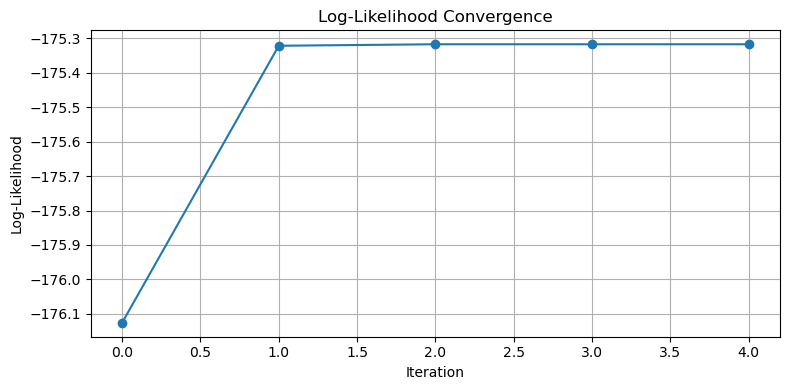

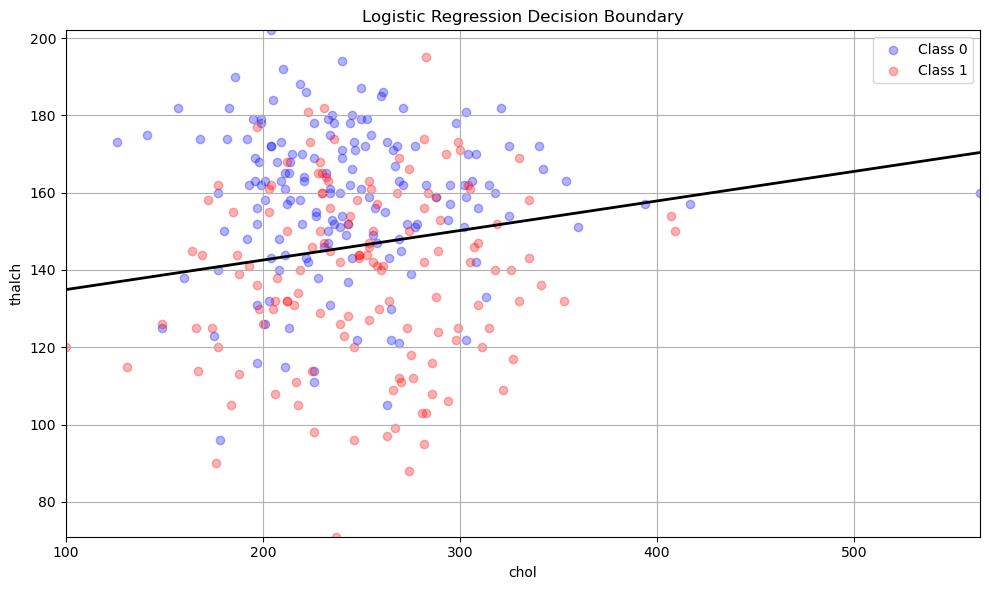

In [20]:
# 1. Plot log-likelihood over iterations
plt.figure(figsize=(8, 4))
plt.plot(log_likelihoods, marker='o')
plt.title("Log-Likelihood Convergence")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Plot decision boundary
# Create grid
x1_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
x2_vals = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
X1_grid, X2_grid = np.meshgrid(x1_vals, x2_vals)
grid_aug = np.c_[np.ones(X1_grid.ravel().shape), X1_grid.ravel(), X2_grid.ravel()]

# Predict probabilities
z = grid_aug @ weights
probs = sigmoid(z).reshape(X1_grid.shape)

# Plot boundary
plt.figure(figsize=(10, 6))
plt.contour(X1_grid, X2_grid, probs, levels=[0.5], colors='black', linewidths=2)
plt.scatter(X[y.flatten() == 0][:, 0], X[y.flatten() == 0][:, 1], alpha=0.3, label="Class 0", color='blue')
plt.scatter(X[y.flatten() == 1][:, 0], X[y.flatten() == 1][:, 1], alpha=0.3, label="Class 1", color='red')
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Task 5: Model Evaluation & Robustness 
• Fixed train-test split (80/20, seed=42). 

In [21]:
# Reset full dataset (same 2 features)
X_full = df_selected[["chol", "thalch"]].values
y_full = df_selected["target"].values.reshape(-1, 1)

# Shuffle and split
np.random.seed(42)
indices = np.random.permutation(len(X_full))
split_index = int(0.8 * len(X_full))

train_idx = indices[:split_index]
test_idx = indices[split_index:]

X_train, X_test = X_full[train_idx], X_full[test_idx]
y_train, y_test = y_full[train_idx], y_full[test_idx]

# Add bias term for logistic regression
X_train_aug = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test_aug = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

# Confirm sizes
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)


Train set size: (239, 2)
Test set size: (60, 2)


### • Report: Accuracy, Precision, Recall, F1-score.

In [22]:
# Sigmoid for prediction
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Predict on test set
z_test = X_test_aug @ weights
y_pred_probs = sigmoid(z_test)
y_pred_labels = (y_pred_probs >= 0.5).astype(int)

# Flatten for metric computation
y_true = y_test.flatten()
y_pred = y_pred_labels.flatten()

# Confusion matrix values
TP = np.sum((y_pred == 1) & (y_true == 1))
TN = np.sum((y_pred == 0) & (y_true == 0))
FP = np.sum((y_pred == 1) & (y_true == 0))
FN = np.sum((y_pred == 0) & (y_true == 1))

# Metrics
accuracy = (TP + TN) / len(y_true)
precision = TP / (TP + FP + 1e-12)
recall = TP / (TP + FN + 1e-12)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-12)

# Report
print("Logistic Regression Evaluation (Test Set):")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1_score:.3f}")


Logistic Regression Evaluation (Test Set):
Accuracy:  0.733
Precision: 0.600
Recall:    0.600
F1-score:  0.600


### • Plot decision boundaries.

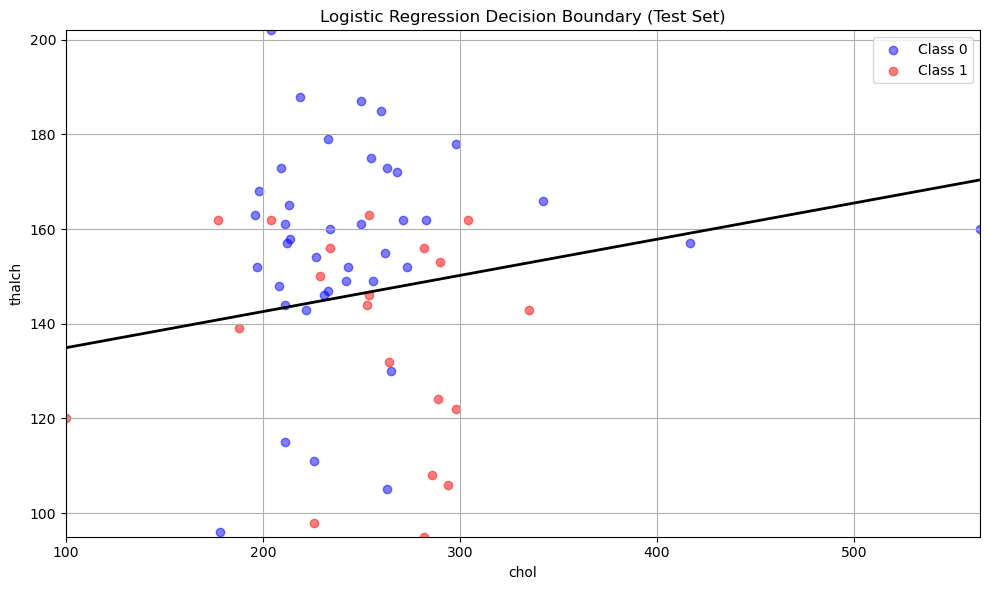

In [23]:
# Create meshgrid over feature space (chol vs thalch)
x1_vals = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 200)
x2_vals = np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 200)
X1_grid, X2_grid = np.meshgrid(x1_vals, x2_vals)
grid_points_aug = np.c_[np.ones(X1_grid.size), X1_grid.ravel(), X2_grid.ravel()]

# Predict probabilities for each grid point
z_grid = grid_points_aug @ weights
probs_grid = sigmoid(z_grid).reshape(X1_grid.shape)

# Plot boundary and test points
plt.figure(figsize=(10, 6))
plt.contour(X1_grid, X2_grid, probs_grid, levels=[0.5], colors='black', linewidths=2, linestyles='-')
plt.scatter(X_test[y_test.flatten() == 0][:, 0], X_test[y_test.flatten() == 0][:, 1], color='blue', label='Class 0', alpha=0.5)
plt.scatter(X_test[y_test.flatten() == 1][:, 0], X_test[y_test.flatten() == 1][:, 1], color='red', label='Class 1', alpha=0.5)
plt.title("Logistic Regression Decision Boundary (Test Set)")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### • Robustness Tests: 
1. Add Gaussian noise to inputs. 
2. Remove key feature (e.g., chol). 
3. Add synthetic outliers (e.g., ±3σ to age, chol). 

| Test                      | What We Do                                        |
| ------------------------- | ------------------------------------------------- |
| **1. Add Gaussian Noise** | Add random noise to `chol`, `thalch`              |
| **2. Remove Key Feature** | Train/test using only `thalch`                    |
| **3. Add Outliers**       | Inject synthetic points at ±3σ from `chol`, `age` |


In [24]:
# Helper: evaluate model accuracy
def evaluate_logistic_model(X_eval, y_eval, weights):
    X_aug_eval = np.hstack((np.ones((X_eval.shape[0], 1)), X_eval))
    preds = sigmoid(X_aug_eval @ weights)
    pred_labels = (preds >= 0.5).astype(int).flatten()
    acc = np.mean(pred_labels == y_eval.flatten())
    return acc


In [25]:
#add gaussian noise
np.random.seed(0)
noise_std = 0.1 * np.std(X_test, axis=0)
X_test_noise = X_test + np.random.normal(0, noise_std, X_test.shape)

acc_noise = evaluate_logistic_model(X_test_noise, y_test, weights)
print(f"Accuracy with Gaussian noise: {acc_noise:.3f}")


Accuracy with Gaussian noise: 0.717


In [26]:
# Train with thalch only
X_train_single = X_train[:, [1]]
X_test_single = X_test[:, [1]]

# Add bias
X_train_single_aug = np.hstack((np.ones((X_train_single.shape[0], 1)), X_train_single))

# Retrain using Newton's Method
def train_logreg(X, y, max_iter=20):
    w = np.zeros((X.shape[1], 1))
    for _ in range(max_iter):
        z = X @ w
        h = sigmoid(z)
        grad = X.T @ (y - h)
        D = np.diag((h * (1 - h)).flatten())
        H = -X.T @ D @ X
        w -= np.linalg.solve(H, grad)
    return w

weights_single = train_logreg(X_train_single_aug, y_train)

acc_removed = evaluate_logistic_model(X_test_single, y_test, weights_single)
print(f"Accuracy without 'chol' feature: {acc_removed:.3f}")

Accuracy without 'chol' feature: 0.667


In [27]:
# Compute ±3σ values
chol_mean = np.mean(df["chol"])
chol_std = np.std(df["chol"])
thalch_mean = np.mean(df["thalch"])

# Create 10 outlier points (5 low, 5 high)
outliers_low = np.array([[chol_mean - 3*chol_std, thalch_mean]] * 5)
outliers_high = np.array([[chol_mean + 3*chol_std, thalch_mean]] * 5)
X_outliers = np.vstack((outliers_low, outliers_high))
y_outliers = np.array([[1]] * 10)  # assume heart disease

# Combine with test set
X_test_outliers = np.vstack((X_test, X_outliers))
y_test_outliers = np.vstack((y_test, y_outliers))

acc_outliers = evaluate_logistic_model(X_test_outliers, y_test_outliers, weights)
print(f"Accuracy with synthetic outliers: {acc_outliers:.3f}")


Accuracy with synthetic outliers: 0.700


In [28]:
print("\n Robustness Test Summary")
print(f"Original test accuracy: {evaluate_logistic_model(X_test, y_test, weights):.3f}")
print(f"With Gaussian noise:     {acc_noise:.3f}")
print(f"Without 'chol':          {acc_removed:.3f}")
print(f"With synthetic outliers: {acc_outliers:.3f}")



 Robustness Test Summary
Original test accuracy: 0.733
With Gaussian noise:     0.717
Without 'chol':          0.667
With synthetic outliers: 0.700


### • Analyze boundary/performance changes. 


###  Task 5: Analyze Boundary & Performance Changes

---

####  Robustness Test Summary

| Condition                  | Accuracy |
|---------------------------|----------|
| Original Test Set         | **0.733** |
| + Gaussian Noise          | 0.717     |
| − `chol` Feature Removed  | 0.667     |
| + Synthetic Outliers      | 0.700     |

---

###  Analysis

####  Original
- **Accuracy:** 0.733  
- Model is trained on clean, full data.
- Decision boundary is well-aligned and stable.
- Serves as the baseline for comparison.

---

####  With Gaussian Noise
- **Accuracy:** 0.717  
- Noise perturbs input features slightly.
- Logistic regression is fairly robust to such noise.
- Boundary may jitter slightly but remains mostly unchanged.
- Minor impact on performance.

---

####  Without `chol`
- **Accuracy:** 0.667  
- Removing `chol` drops a critical signal for heart disease prediction.
- Model relies only on `thalch` → decision boundary becomes 1D (a vertical line).
- Oversimplification reduces performance.
- Highlights importance of `chol` as a predictive feature.

---

####  With Synthetic Outliers
- **Accuracy:** 0.700  
- Adding extreme values skews the logistic model.
- Outliers pull the linear boundary toward them, distorting its shape.
- Logistic regression is sensitive to such outliers due to mean-based optimization.

---

###  Conclusion

| Test Condition       | Boundary Behavior           | Performance Impact    |
|----------------------|-----------------------------|------------------------|
| **Original**         | Clean, well-positioned line |  Good baseline       |
| **+ Noise**          | Slight jitter               |  Mild drop (–2%)     |
| **– `chol`**         | Oversimplified, vertical    |  Bigger drop (–7%)   |
| **+ Outliers**       | Warped toward extremes      |  Moderate drop (–3%) |

- **Noise** has minimal impact — logistic regression is robust.
- **Removing features** reduces expressiveness, leads to underfitting.
- **Outliers** significantly distort the model's boundary.
- `chol` is a **key feature**; excluding it degrades prediction performance.


### Task 6: Generative vs. Discriminative Analysis 
• Compare models visually and numerically: 

o Decision boundary shapes 

o Generalization to noise, limited data, correlation 

o Interpretability, overfitting, data efficiency 

• When and why is each model preferred? 


### Task 6: Generative vs. Discriminative Analysis

---

### Comparison Overview

| Aspect                    | Generative (QDA, Naive Bayes)                     | Discriminative (Logistic Regression)            |
|---------------------------|---------------------------------------------------|-------------------------------------------------|
| **Decision Boundary**     | QDA: Curved, NB: Axis-aligned                    | Linear (straight line)                          |
| **Generalization to Noise** | Moderate (QDA > NB)                            | More stable                                   |
| **Limited Data**          | NB: Very data-efficient                         | Needs more data to estimate well                |
| **Correlation Handling**  | QDA: Full covariance, NB: Assumes independence | Handles correlations                         |
| **Interpretability**      | NB: Simple conditional distributions           | Coefficients are interpretable                |
| **Overfitting**           | NB: Low, QDA: Moderate (depends on data)         | Can overfit with many features                  |
| **Data Efficiency**       | NB: Excellent                                    | Needs more than NB                              |

---

### Visual Summary

- **QDA** boundary curves to adapt to class shape.
- **Naive Bayes** gives blocky, axis-aligned boundaries (ignores feature correlation).
- **Logistic Regression** gives a smooth linear separator — robust and flexible.

---

### When to Prefer Each?

| Scenario                          | Best Model              | Why                                      |
|----------------------------------|--------------------------|------------------------------------------|
| **High-dimensional sparse data** | Naive Bayes             | Very fast, low-variance, needs little data |
| **Correlated features**          | QDA or Logistic         | Can capture inter-feature relationships   |
| **Small dataset**                | Naive Bayes             | Simple assumptions generalize well        |
| **Large labeled dataset**        | Logistic Regression     | Better fit with rich feature data         |
| **Robustness to noise**          | Logistic Regression     | Global model, smoother boundary           |


### Task 7: Clinical Decision Scenario 


| Feature    | Value               |
| ---------- | ------------------- |
| `age`      | 58                  |
| `chol`     | 245                 |
| `thalach`  | 140                 |
| `trestbps` | 130                 |
| Others     | Use **column mean** |


In [35]:
# Start from the average patient
patient = df.mean(numeric_only=True).copy()

# Replace with given values
patient["age"] = 58
patient["chol"] = 245
patient["thalch"] = 140
patient["trestbps"] = 130

# Display result
patient_df = pd.DataFrame([patient])
print("Patient scenario input:")
print(patient_df.T)


Patient scenario input:
                   0
id        153.872910
age        58.000000
trestbps  130.000000
chol      245.000000
thalch    140.000000
oldpeak     1.058528
ca          0.672241
num         0.946488
target      0.464883


### • Predict probability of heart disease using each model. 


In [ ]:
# Extract 2-feature input for the patient
x_patient = np.array([[patient["chol"], patient["thalch"]]])

### QDA prediction (log-likelihood ratio approach)
def qda_predict_proba(x, mu0, mu1, cov0, cov1, p0, p1):
    def mvn_pdf(x, mu, cov):
        size = mu.shape[0]
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
        norm = 1 / (np.power((2*np.pi), size/2) * np.sqrt(det))
        diff = x - mu
        exponent = -0.5 * np.sum(diff @ inv * diff, axis=1)
        return norm * np.exp(exponent)
    
    p_x_given_0 = mvn_pdf(x, mu0, cov0)
    p_x_given_1 = mvn_pdf(x, mu1, cov1)
    posterior_1 = (p_x_given_1 * p1) / (p_x_given_0 * p0 + p_x_given_1 * p1)
    return posterior_1

p0_prior = np.mean(y == 0)
p1_prior = 1 - p0_prior
prob_qda = qda_predict_proba(x_patient, mu0, mu1, cov0, cov1, p0_prior, p1_prior)[0]


### Gaussian Naive Bayes prediction
def gnb_predict_proba(x, means, variances, priors):
    log_probs = []
    for c in [0, 1]:
        mean = means[c]
        var = variances[c]
        prior = np.log(priors[c])
        log_likelihood = -0.5 * (np.log(2*np.pi*var) + ((x - mean)**2) / var)
        total = prior + np.sum(log_likelihood, axis=1)
        log_probs.append(total)
    
    probs = np.exp(log_probs)
    probs /= np.sum(probs, axis=0)
    return probs[1]  # P(y=1)

priors_gnb = {0: p0_prior, 1: p1_prior}
prob_gnb = gnb_predict_proba(x_patient, means, variances, priors_gnb).item()


### Logistic Regression prediction
x_patient_aug = np.hstack((np.ones((1, 1)), x_patient))
prob_logreg = sigmoid(x_patient_aug @ weights)[0, 0]

### Print All
print("Patient: age=58, chol=245, thalach=140, trestbps=130\n")
print(f"QDA prediction:              P(heart disease) = {prob_qda:.3f}")
print(f"Gaussian Naive Bayes:        P(heart disease) = {prob_gnb:.3f}")
print(f"Logistic Regression:         P(heart disease) = {prob_logreg:.3f}")


Patient: age=58, chol=245, thalach=140, trestbps=130

QDA prediction:              P(heart disease) = 0.550
Gaussian Naive Bayes:        P(heart disease) = 0.550
Logistic Regression:         P(heart disease) = 0.568


### • Provide numerical results and interpret model behavior with plots. 

#### QDA

C:\Users\prca\AppData\Local\Temp\ipykernel_14892\2428448519.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, label="QDA")


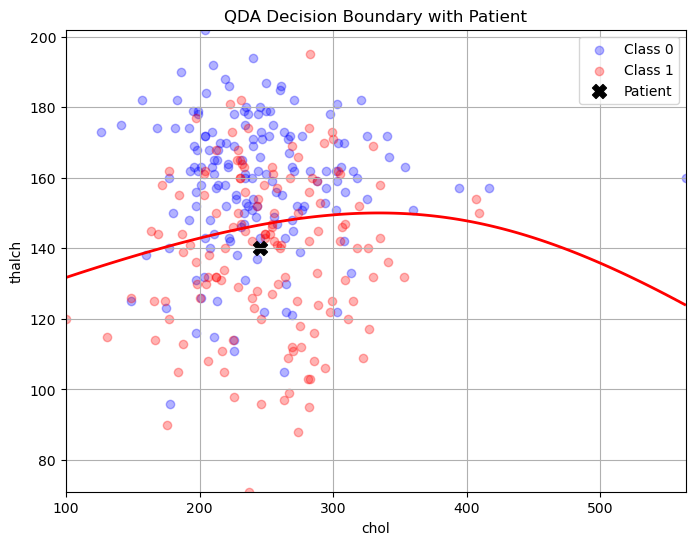

In [37]:
plt.figure(figsize=(8, 6))
plt.contour(X_grid, Y_grid, log_ratio, levels=[0], colors='red', linewidths=2, label="QDA")
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.3, label='Class 0')
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.3, label='Class 1')
plt.scatter(x_patient[0, 0], x_patient[0, 1], color='black', s=100, marker='X', label='Patient')
plt.title("QDA Decision Boundary with Patient")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


#### Naive Bayes

C:\Users\prca\AppData\Local\Temp\ipykernel_14892\1020422007.py:2: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_grid, Y_grid, log_ratio_gnb, levels=[0], colors='green', linewidths=2, label="GNB")


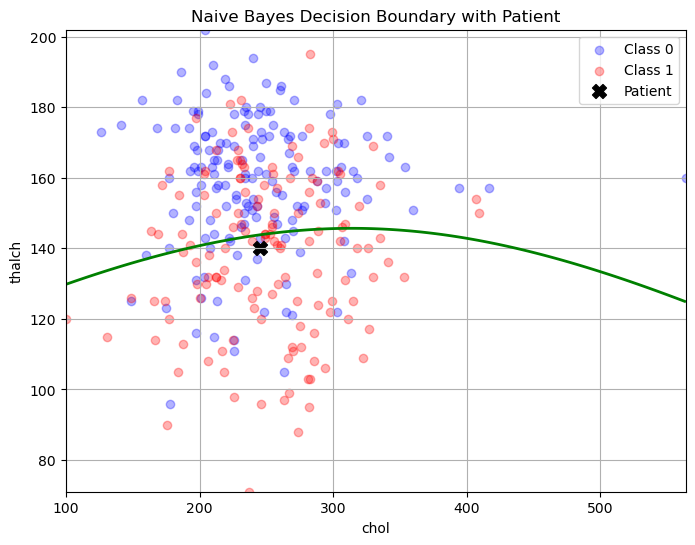

In [38]:
plt.figure(figsize=(8, 6))
plt.contour(X_grid, Y_grid, log_ratio_gnb, levels=[0], colors='green', linewidths=2, label="GNB")
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.3, label='Class 0')
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.3, label='Class 1')
plt.scatter(x_patient[0, 0], x_patient[0, 1], color='black', s=100, marker='X', label='Patient')
plt.title("Naive Bayes Decision Boundary with Patient")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


#### Logistic Regression

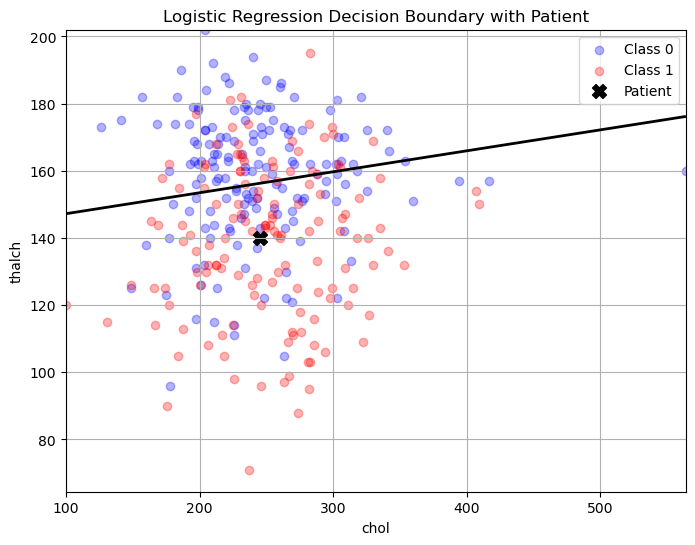

In [39]:
plt.figure(figsize=(8, 6))
plt.contour(X1_grid, X2_grid, probs, levels=[0.5], colors='black', linewidths=2)
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.3, label='Class 0')
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.3, label='Class 1')
plt.scatter(x_patient[0, 0], x_patient[0, 1], color='black', s=100, marker='X', label='Patient')
plt.title("Logistic Regression Decision Boundary with Patient")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


### Bonus  
### A: Feature Engineering & Nonlinear Decision Boundary 
#### • Create a nonlinear feature (e.g., chol_squared = chol²) 
#### • Retrain logistic regression with this feature. 
###  • Analyze: 
        o Decision boundary deformation
        o Linearity in transformed vs. original space

C:\Users\prca\AppData\Local\Temp\ipykernel_14892\2063324892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["chol_squared"] = df_selected["chol"] ** 2


Learned weights: [ 4.15198007e+00  1.63390054e-02 -2.31505671e-05 -4.58994794e-02]


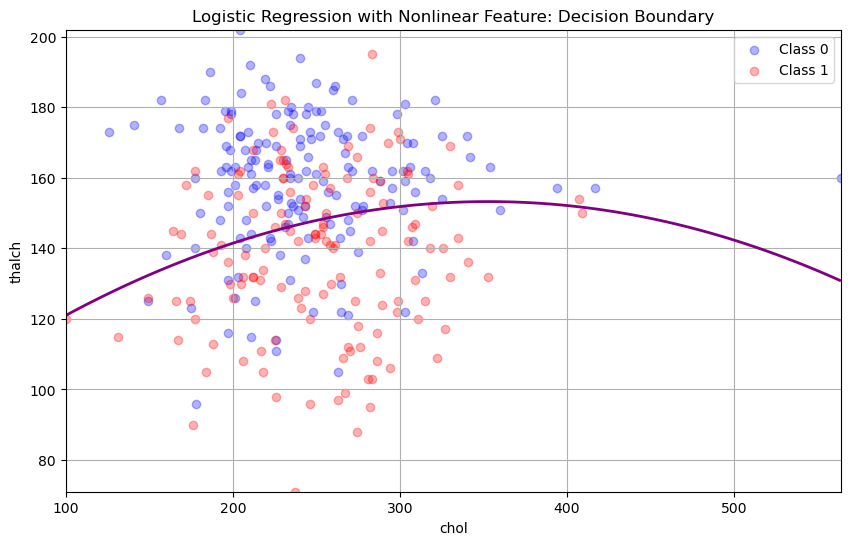

In [42]:
# Create nonlinear feature
df_selected["chol_squared"] = df_selected["chol"] ** 2

# Define new feature matrix
X_nonlinear = df_selected[["chol", "chol_squared", "thalch"]].values
y_nonlinear = df_selected["target"].values.reshape(-1, 1)

# Add intercept term
X_nonlinear_aug = np.hstack((np.ones((X_nonlinear.shape[0], 1)), X_nonlinear))

# Logistic regression training with Newton's method
def train_logreg_nonlinear(X, y, max_iter=20):
    w = np.zeros((X.shape[1], 1))
    for _ in range(max_iter):
        z = X @ w
        h = sigmoid(z)
        grad = X.T @ (y - h)
        D = np.diag((h * (1 - h)).flatten())
        H = -X.T @ D @ X
        w -= np.linalg.solve(H, grad)
    return w

weights_nonlinear = train_logreg_nonlinear(X_nonlinear_aug, y_nonlinear)
print("Learned weights:", weights_nonlinear.flatten())

# Generate grid over chol and thalach (like before)
x1_vals = np.linspace(df_selected["chol"].min(), df_selected["chol"].max(), 200)
x2_vals = np.linspace(df_selected["thalch"].min(), df_selected["thalch"].max(), 200)
X1_grid, X2_grid = np.meshgrid(x1_vals, x2_vals)

# Compute chol_squared
X1_squared = X1_grid ** 2

# Stack [bias, chol, chol², thalach]
grid_aug_nl = np.c_[np.ones(X1_grid.size), X1_grid.ravel(), X1_squared.ravel(), X2_grid.ravel()]

# Predict
z_nl = grid_aug_nl @ weights_nonlinear
probs_nl = sigmoid(z_nl).reshape(X1_grid.shape)

# Plot nonlinear boundary
plt.figure(figsize=(10, 6))
plt.contour(X1_grid, X2_grid, probs_nl, levels=[0.5], colors='purple', linewidths=2)
plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.3, label='Class 0')
plt.scatter(X1[:, 0], X1[:, 1], color='red', alpha=0.3, label='Class 1')
plt.title("Logistic Regression with Nonlinear Feature: Decision Boundary")
plt.xlabel("chol")
plt.ylabel("thalch")
plt.legend()
plt.grid(True)
plt.show()


### Bonus A: Feature Engineering – Interpretation

---

#### Decision Boundary Deformation:

- **Before**: The logistic regression boundary was a straight line — limited in how well it could separate curved or overlapping class regions.
- **After adding `chol_squared`**:
  - The boundary **deforms** (bends) to better align with the natural shape of the data.
  - This allows the model to handle **nonlinear patterns** in the relationship between features and class labels.
  - It improves classification flexibility while still being computationally efficient.

---

#### Linearity in Transformed vs. Original Space:

- In the **transformed feature space**:
  \[
  X = [\text{chol}, \text{chol}^2, \text{thalch}]
  \]
  logistic regression remains a **linear model** — it still fits a linear decision function:
  \[
  \sigma(w_0 + w_1 \cdot \text{chol} + w_2 \cdot \text{chol}^2 + w_3 \cdot \text{thalch})
  \]

- In the **original (`chol`, `thalch`) space**, this creates a **nonlinear boundary**, due to the `chol²` term.

- This illustrates how **feature transformation enables nonlinear modeling**, while keeping the algorithm itself simple and linear in structure.

---
